In [143]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import pylab
import calendar

from sklearn import tree, linear_model, svm
from sklearn.cross_validation import train_test_split
import sklearn.ensemble as ske
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier


First, we load the data and visualize the first lines of the dataframe:

In [141]:
bike_data = pd.read_csv("PSD/Bike-Sharing-Dataset/hour.csv")
bike_data.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


We next check if there are any missing values, because, in that case we would need to treat them, whether by removing the corresponding rows (if they are few or they do not affect the analysis) or otherwise we could use some imputing method. As shown below, there is no need for that as there are no missing values.

In [142]:
bike_data.isnull().values.any()


False

We now perform some exploratory data analysis that will allow us to understand better the data. Given that the "cnt" column is the addition of the "casual" and "registered" columns we will analyse those columns independently to check if they follow different trends.

The first couple of plots correspond to the represenation of the number of casual and registered rides, respectively, during all the months of the two years. We observe that there are more "registered" than "casual" riders. The number of "casual" riders decreases during the winter months, while the numbers of "registered" riders does not undergo such a substantial decrease during the winter. Besides, the number of "registered" riders has significantly increased in 2012, while the numbers of "casual" riders has not undergone any substantial increase from 2011 to 2012. 

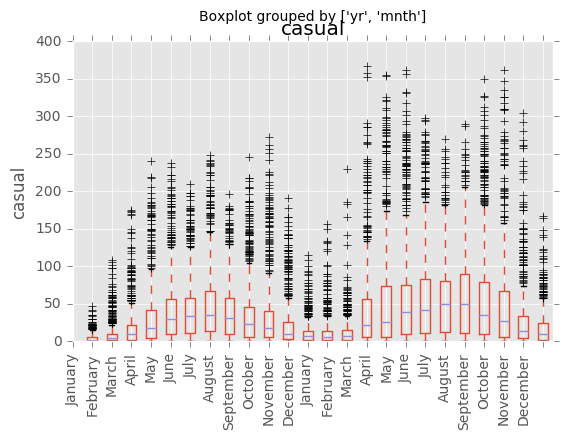

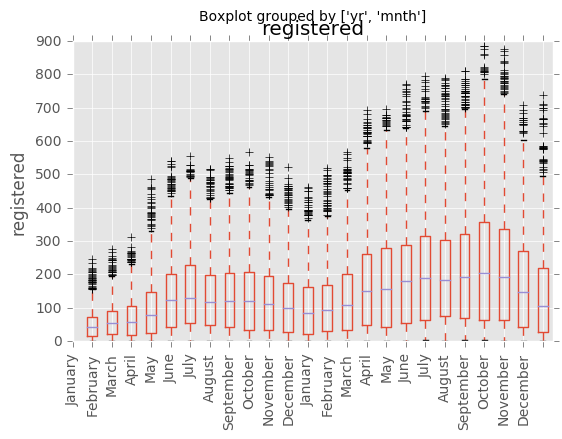

In [5]:
plt.style.use("ggplot")
bike_data.boxplot(column=["casual"], by = ["yr", "mnth"])
plt.xlabel("")
plt.ylabel("casual")
plt.xticks(np.arange(0,len(bike_data)/710,len(bike_data)/17379), calendar.month_name[1:13]*2, rotation=90)
plt.show()
bike_data.boxplot(column=["registered"], by = ["yr", "mnth"])
plt.xlabel("")
plt.ylabel("registered")
plt.xticks(np.arange(0,len(bike_data)/710,len(bike_data)/17379), calendar.month_name[1:13]*2, rotation=90)
plt.show()

In the next couple of boxplots, we analyze the hourly trend of the riders. "Casual" riders use the service mainly from 9am to 10pm. During this frametime the distribution of the "casual" users follows a shallow inverted parabola shape. On the other hand, "registered" users present a very different trend: two sharp peaks (at 7am-8am and 5pm-6pm) are clearly distinguished. Given this hourly pattern, one can easily conclude that "registered" users employ the bike sharing service for commuting to work/university. 


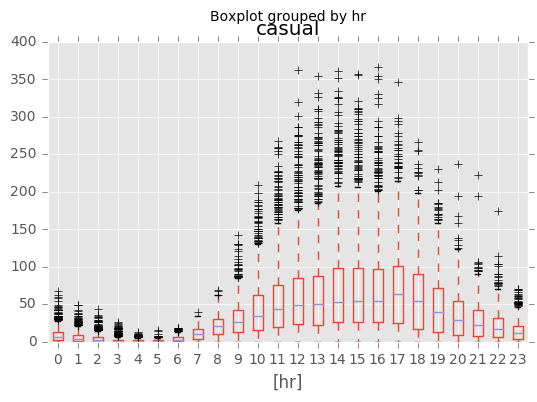

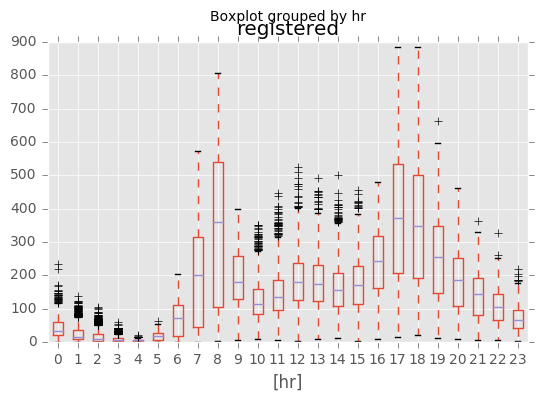

In [7]:
plt.style.use("ggplot")
bike_data.boxplot(column=["casual"], by = ["hr"])
bike_data.boxplot(column=["registered"], by = ["hr"])
plt.show()

Regarding the daily pattern shown below, we see that "casual" riders employ the service mainly during the weekend, while "registered" users present a more monotonous behavior with a slightly more frequent number of rides from Monday to Friday. These plots indicate that "casual" users employ the service in their free time, while "registered" use it as a commuting service but also during weekends.

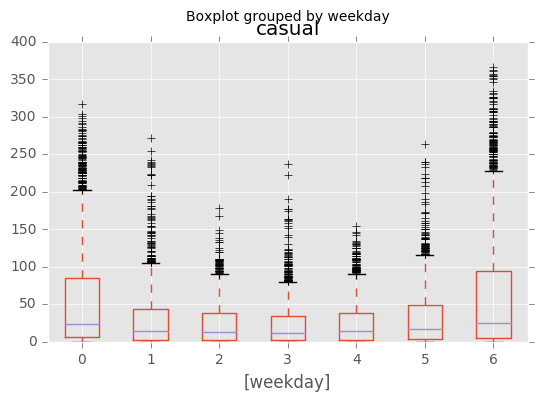

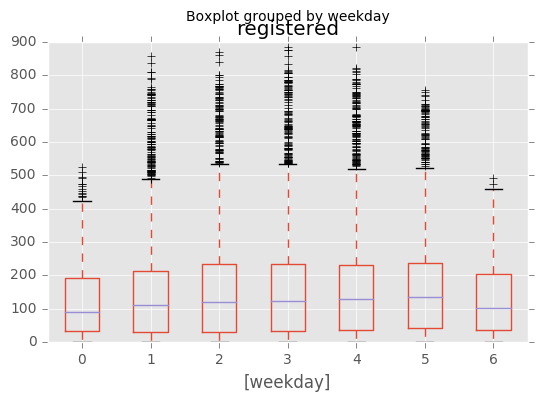

In [8]:
plt.style.use("ggplot")
bike_data.boxplot(column=["casual"], by = ["weekday"])
bike_data.boxplot(column=["registered"], by = ["weekday"])
plt.show()

Regarding the temperature conditions, we have divided the range of temperatures in 10 groups, shown in the histograms below. As expected, both "casual" and "registered" users prefer warm temperatures for riding. The temperature range with most users is 27º-32º (0.75-0.85) for both type of users.

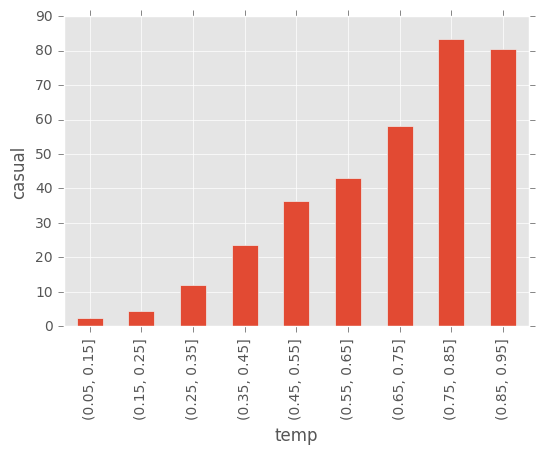

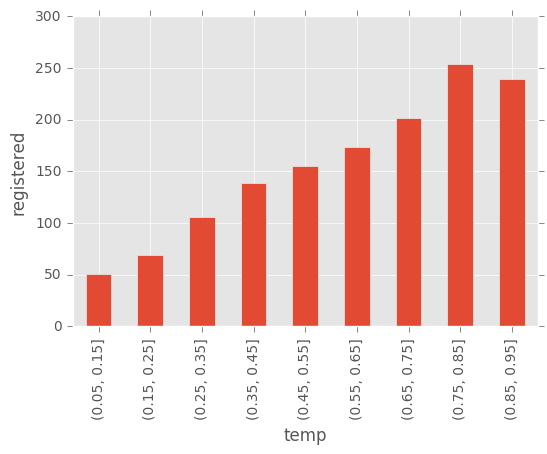

In [9]:
group_by_temp = pd.cut(bike_data["temp"], np.arange(0.05,1.05,0.1))
temp_grouping = bike_data.groupby(group_by_temp).mean()
temp_grouping["casual"].plot.bar()
plt.ylabel("casual")
plt.show()
temp_grouping["registered"].plot.bar()
plt.ylabel("registered")
plt.show()

We will next start with the prediction. For that, we will eliminate the columns of the dataframe that do not provide any relevant information ("instant") or are difficult to use in a classification algorithm ("dteday"). 

In [10]:
bike_data.drop(["dteday", "instant"], 1, inplace=True)

In [11]:
bike_data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We now use as predictors all the variables, except "casual", "registered", and "cnt", which are the outcome to be predicted. We will train the classification algorithms with "casual" and "registered" separately, given the fact that they follow different trends. In the last step we will add the contributions of "casual" and "registered", to predict "cnt".  

In [12]:
X = bike_data.iloc[:,:12]
y = bike_data.iloc[:,12:15]

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1234)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

The first classification algorithm we use is a linear regression. It has a very poor performance so we discard it.

In [145]:
linear_regression_casual = linear_model.LinearRegression()
linear_regression_casual.fit(X_train, y_train[::,0])
linear_regression_casual.score(X_test, y_test[::,0])

0.48134872310673205

In [23]:
linear_regression_registered = linear_model.LinearRegression()
linear_regression_registered.fit(X_train, y_train[::,1])
linear_regression_registered.score(X_test, y_test[::,1])

0.34677167106358309

Next, we use Random Forest. We see that this model correctly predicts 91.1% of the "casual" users and 94.5% of the "registered" users. The feature importance analysis indicates that the most important predictors for "casual" users are "hr", followed by "workingday" and "temp". For "registered" users "hr" (by far!, not suprising given the boxplot shown above) followed by "workingday".

In [146]:
rf_casual = ske.RandomForestRegressor(n_estimators=1800, min_samples_split = 10, random_state = 0)
rf_casual.fit(X_train, y_train[::,0])
rf_casual.score(X_test, y_test[::,0]), rf_casual.feature_importances_

(0.91103708234902792,
 array([ 0.00680919,  0.04209425,  0.02178033,  0.37678038,  0.00504806,
         0.01771198,  0.19613389,  0.00727684,  0.14457478,  0.11649593,
         0.05069869,  0.01459568]))

In [30]:
rf_registered = ske.RandomForestRegressor(n_estimators=1800, min_samples_split = 10, random_state = 0)
rf_registered.fit(X_train, y_train[::,1])
rf_registered.score(X_test, y_test[::,1]), rf_registered.feature_importances_


(0.94529490529947213,
 array([ 0.03327026,  0.08670956,  0.02317074,  0.57652064,  0.00204674,
         0.00959275,  0.15136129,  0.01690182,  0.04356008,  0.03109698,
         0.0204191 ,  0.00535003]))

Below, we present the use of a Gradient Boosting Regressor, whose performance here is a little better than Random Forest: 92.9% of correct predictions for "casual" users and 95.2% for "registered" users. Regarding feature importance "hr" followed by "hum" and "windspeed" are the most influencial predictors in the case of the "casual" users. For "registered" users "hr" and "windspeed" show the larger contribution. 

In [41]:
gbm_casual = ske.GradientBoostingRegressor(n_estimators=200, max_depth = 8, random_state = 0)
gbm_casual.fit(X_train, y_train[::,0])
gbm_casual.score(X_test, y_test[::,0]), gbm_casual.feature_importances_

(0.92927778792420535,
 array([ 0.02308537,  0.0300283 ,  0.10285613,  0.18836714,  0.0091528 ,
         0.10296613,  0.03868424,  0.02525484,  0.10304591,  0.10774962,
         0.14707264,  0.1217369 ]))

In [42]:
gbm_registered = ske.GradientBoostingRegressor(n_estimators=200, max_depth = 8, random_state = 0)
gbm_registered.fit(X_train, y_train[::,1])
gbm_registered.score(X_test, y_test[::,1]), gbm_registered.feature_importances_

(0.95220604367685713,
 array([ 0.02629464,  0.03573394,  0.0724434 ,  0.2566386 ,  0.00745785,
         0.0854516 ,  0.04926676,  0.0388993 ,  0.08838223,  0.09003843,
         0.14912469,  0.10026857]))

We now make predictions for "casual" and "registered" users (both with Random Forest and Generalized Boosting) and add them up to obtain the prediction for "cnt". Finally the MAE is calculated. 

In [52]:
#1. Random forest
predict_rf_casual = rf_casual.predict(X_test)
predict_rf_registered = rf_registered.predict(X_test)
predict_rf_total = [x + y for (x,y) in zip(predict_rf_casual, predict_rf_registered)]
MAE = 1/len(predict_rf_total)*sum(abs(predict_rf_total - y_test[::,2]))
print("MAE(Random Forest) = %.2f" %(MAE))

MAE(Random Forest) = 25.20


In [53]:
#2. Gradient Boosting Regressor
predict_gb_casual = gbm_casual.predict(X_test)
predict_gb_registered = gbm_registered.predict(X_test)
predict_gb_total = [x + y for (x,y) in zip(predict_gb_casual,predict_gb_registered)]
MAE = 1/len(predict_gb_total)*sum(abs(predict_gb_total -y_test[::,2]))
print("MAE(Gradient Boosting) = %.2f" %(MAE))

MAE(Gradient Boosting) = 23.14


Below, we present a dataframe with two columns: the evaluation "cnt" set and our predicted "cnt" set. They are shown both for Random Forest and Gradient Boosting.

In [136]:
df_rf = pd.DataFrame({"x": y_test[::,2], "y": predict_rf_total})
df_rf = df_rf.rename(columns={"x":"cnt_test", "y" :"cnt_predicted"})
df_rf.head()

,cnt_test,cnt_predicted
0,330,381.604229
1,351,323.222439
2,3,9.213973
3,202,263.340536
4,86,129.831877


In [140]:
df_gbm = pd.DataFrame({"x": y_test[::,2], "y": predict_gb_total})
df_gbm = df_rf.rename(columns={"x":"cnt_test", "y" :"cnt_predicted"})
df_gbm.head()

,cnt_test,cnt_predicted
0,330,381.604229
1,351,323.222439
2,3,9.213973
3,202,263.340536
4,86,129.831877


So far, we have observed that "hr" is, by far, the most important of all the predictors, espcially for "registered" users. Therefore, we will add another variable to the dataframe that creates bins of the "hr" variable according to the number or "registered" users. As shown below, we have divided the "registered" users in 7 groups following their hourly pattern.

In [125]:
import warnings
warnings.filterwarnings('ignore')

bike_data["groupby_hours_registered"] = 0

bike_data.groupby_hours_registered[bike_data.hr <=6 ] = 1
bike_data.groupby_hours_registered[(bike_data.hr == 7)] = 2
bike_data.groupby_hours_registered[(bike_data.hr == 8)] = 3
bike_data.groupby_hours_registered[(bike_data.hr >= 9) & (bike_data.hr <= 16)] = 4
bike_data.groupby_hours_registered[(bike_data.hr == 17) | (bike_data.hr == 18)] = 5
bike_data.groupby_hours_registered[(bike_data.hr == 19) | (bike_data.hr == 20)] = 6
bike_data.groupby_hours_registered[(bike_data.hr >= 21) & (bike_data.hr <= 23)] = 7
bike_data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,groupby_hours_registered
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


We now follow the same procedure as before, divide our data in training and testing set and check if the performance of the classification algorithm for the "registered" users improves by the addition of this new variable.

In [130]:
X_extended = bike_data.iloc[:,:12].join(bike_data.iloc[:, -1])
y_extended= bike_data.iloc[:,12:15]


In [131]:
X_extended_train, X_extended_test, y_extended_train, y_extended_test = train_test_split(X_extended, y_extended, test_size = 0.1, random_state = 1234)

X_extended_train_registered= np.array(X_extended_train)
X_extended_test_registered = np.array(X_extended_test)
y_extended_train = np.array(y_extended_train)
y_extended_test = np.array(y_extended_test)


As shown below the addition of the variable "groupby_hours_registered" does not improve the prediction of the "registered" users. In the case of Random Forest and Gradient Boosting classifiers, we obtain the same accuracy of 94.5% and 95.3%, respectively, as before. 

In [132]:
rf_registered_extended = ske.RandomForestRegressor(n_estimators= 1800, min_samples_split = 10, random_state = 0)
rf_registered_extended.fit(X_extended_train_registered, y_extended_train[::,1])
rf_registered_extended.score(X_extended_test_registered, y_extended_test[::,1]), rf_registered_extended.feature_importances_

(0.94531481633555703,
 array([ 0.03327926,  0.08670953,  0.02315997,  0.31684404,  0.00204891,
         0.00959117,  0.15136249,  0.01691288,  0.04389185,  0.03075527,
         0.02041794,  0.00534923,  0.25967747]))

In [133]:
gbm_registered_extended = ske.GradientBoostingRegressor(n_estimators=200, max_depth = 8, random_state = 0)
gbm_registered_extended.fit(X_extended_train_registered, y_extended_train[::,1])
gbm_registered_extended.score(X_extended_test_registered, y_extended_test[::,1]), gbm_registered_extended.feature_importances_

(0.95255499103967844,
 array([ 0.02572884,  0.0361038 ,  0.07291446,  0.18083078,  0.00731354,
         0.08510385,  0.04864104,  0.03867984,  0.08506381,  0.0923936 ,
         0.14830068,  0.09988952,  0.07903625]))

One could also try to create new variables by grouping other influencial predictors such as "hum" or "workingday" into bins, as done in the case of "hr" and check if this yields a better accuracy. However, given that there is basically no improvement using this procedure with the most important predictor ("hr"), a similar result could be expected for the other variables.  